# Data imputation
[TOC]

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from mlens.visualization import pca_comp_plot
from matplotlib import pyplot as plt

from data import feature, get_severity, z_score_normalize, z_score_denormalize, fill_dataset

seed = 0
np.random.seed(seed)

def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=8)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((32, 64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=64, random_state=seed)
    rf = RandomForestClassifier(n_estimators=64, max_features=2, random_state=seed)
    ab = AdaBoostClassifier(n_estimators=64, random_state=seed)
    xgb = XGBClassifier(random_state=seed)        
    models = {'svm': svc, 
              'knn': knn, 
              'naive bayes': nb,
              'mlp': nn,
              'random forest': rf,
              'gradient boost': gb,
              'logistic': lr,
              'adaboost': ab,
              'xgboost': xgb, 
             }
    return models

def sensitivity_specificity(cm):
    return cm[1, 1] / np.sum(cm[1]), cm[0, 0] / np.sum(cm[0])

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            print('no sample weight')
            m.fit(x_train, y_train)
        try:
            print('\n', name, m.feature_importances_)
        except:
            print('no feature importances')
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=5, scoring='accuracy'):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv, scoring=scoring)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P, scoring='ACC'):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} {} Result {} +/- {}'.format(m, scoring, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    #cm = [plt.cm.gray(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1])]
    cm = sns.color_palette("Blues", P_base_learners.shape[1])
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c='red')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    feature_importances = {}
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            m.fit(x_train, y_train)
            print('no sample_weight')
        try:
            feature_importances.update({name: m.feature_importances_})
        except:
            print('no feature importances')
    print('done.')
    return feature_importances

def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

Using TensorFlow backend.
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

## Read data

In [2]:
# method = 'knn_3'
method = 'knn_5'
# method = 'knn_6'
# method = 'knn_9'
# method = 'softimpute'

In [3]:
train_data_path = './csv/filled_trainSet/filled_{}_trainSet_binary.txt'.format(method)
test_data_path = './csv/filled_testSet/filled_{}_testSet_binary.txt'.format(method)

In [4]:
train_dataset = pd.read_csv(train_data_path, sep=',')
test_dataset = pd.read_csv(test_data_path, sep=',')

y = np.array(train_dataset['severity'])

## Clinical data prediction
Select **imputation** method you want to verify here.

In [5]:
X = z_score_normalize(np.array(train_dataset[feature]))

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


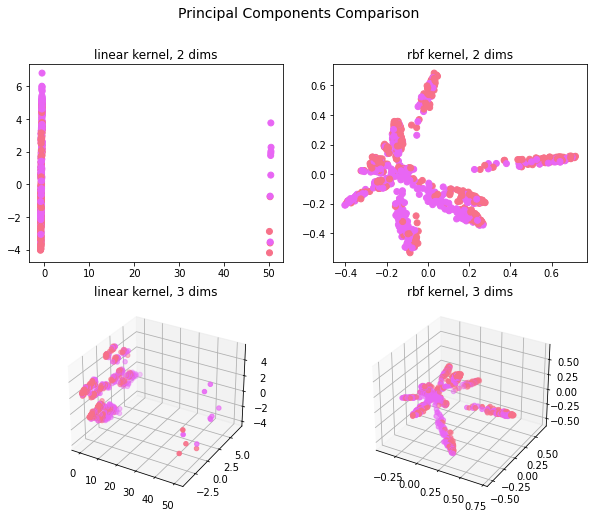

[<AxesSubplot:title={'center':'linear kernel, 2 dims'}>,
 <AxesSubplot:title={'center':'rbf kernel, 2 dims'}>,
 <Axes3DSubplot:title={'center':'linear kernel, 3 dims'}>,
 <Axes3DSubplot:title={'center':'rbf kernel, 3 dims'}>]

In [6]:
pca_comp_plot(X, y)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

样本集大小： (863, 16) (863,)
训练集大小： (690, 16) (690,)
测试集大小： (173, 16) (173,)


In [8]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... no sample weight
no feature importances
done
knn... no sample weight
no feature importances
done
naive bayes... no sample weight
no feature importances
done
mlp... no sample weight
no feature importances
done
random forest... no sample weight

 random forest [0.09332654 0.01101805 0.05586611 0.01340227 0.01812334 0.07443604
 0.09675121 0.08168294 0.12286475 0.07474742 0.091313   0.08606617
 0.11064311 0.05593225 0.0120009  0.00182589]
done
gradient boost... no sample weight

 gradient boost [1.06514007e-01 2.95101540e-04 1.47856712e-02 5.69229171e-03
 3.65401476e-03 3.59740847e-02 7.29716180e-02 4.89545284e-02
 3.19526809e-01 3.68021403e-02 1.40222247e-01 9.08200293e-02
 9.58125390e-02 2.12413783e-02 6.73353944e-03 0.00000000e+00]
done
logistic... no sample weight
no feature importances
done
adaboost... no sample weight

 adaboost [0.078125 0.       0.015625 0.       0.015625 0.0625   0.09375  0.046875
 0.171875 0.09375  0.078125 0.078125 0.140625 0.125    0.  

In [9]:
models = get_models()
cv_results=cross_val_models(models)
cross_val_acc(cv_results)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ACC Result 0.7392996370479903 +/- 0.03138255612748881
knn ACC Result 0.6685979298292781 +/- 0.023503587429050322
naive bayes ACC Result 0.7114733163059551 +/- 0.04472651477341199
mlp ACC Result 0.6720123672536632 +/- 0.054638457241203274
random forest ACC Result 0.7474257292646861 +/- 0.05108433853786662
gradient boost ACC Result 0.740489313079715 +/- 0.03554542134288691
logistic ACC Result 0.7393265223820407 +/- 0.05926419872471089
adaboost ACC Result 0.731227315499395 +/- 0.07660771311035612
xgboost ACC Result 0.7219922032531254 +/- 0.07302242576995657


In [10]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost
0,0.739884,0.676301,0.710983,0.693642,0.745665,0.728324,0.705202,0.763006,0.687861
1,0.722543,0.682081,0.739884,0.710983,0.739884,0.728324,0.722543,0.682081,0.676301
2,0.739884,0.647399,0.682081,0.664740,0.728324,0.722543,0.751445,0.699422,0.722543
3,0.726744,0.668605,0.691860,0.656977,0.726744,0.755814,0.726744,0.726744,0.750000
4,0.767442,0.668605,0.732558,0.633721,0.796512,0.767442,0.790698,0.784884,0.773256


In [11]:
cv_results_roc=cross_val_models(models, scoring='roc_auc')
cross_val_acc(cv_results_roc, scoring='ROC AUC')

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ROC AUC Result 0.8166426946954332 +/- 0.03873873257780443
knn ROC AUC Result 0.7516574466777307 +/- 0.05502105745617962
naive bayes ROC AUC Result 0.8088078554305735 +/- 0.04392656573176395
mlp ROC AUC Result 0.730844089987092 +/- 0.06535909269640058
random forest ROC AUC Result 0.8265515704714488 +/- 0.03144258499567632
gradient boost ROC AUC Result 0.8125579322638148 +/- 0.03559978573216657
logistic ROC AUC Result 0.8228007253057964 +/- 0.04793729283380164
adaboost ROC AUC Result 0.7966064294056181 +/- 0.0714047357872913
xgboost ROC AUC Result 0.7935672137193436 +/- 0.042146802294986824


In [12]:
print("Voting ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Voting ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Voting ROC-AUC score: 0.844
Voting ACC score: 0.803


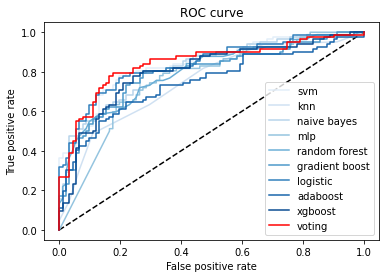

In [13]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [14]:
base_learners = get_models()

In [15]:
meta_learner = GradientBoostingClassifier(
   n_estimators=128,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [16]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.


{'random forest': array([0.09332654, 0.01101805, 0.05586611, 0.01340227, 0.01812334,
        0.07443604, 0.09675121, 0.08168294, 0.12286475, 0.07474742,
        0.091313  , 0.08606617, 0.11064311, 0.05593225, 0.0120009 ,
        0.00182589]),
 'gradient boost': array([1.06514007e-01, 2.95101540e-04, 1.47856712e-02, 5.69229171e-03,
        3.65401476e-03, 3.59740847e-02, 7.29716180e-02, 4.89545284e-02,
        3.19526809e-01, 3.68021403e-02, 1.40222247e-01, 9.08200293e-02,
        9.58125390e-02, 2.12413783e-02, 6.73353944e-03, 0.00000000e+00]),
 'adaboost': array([0.078125, 0.      , 0.015625, 0.      , 0.015625, 0.0625  ,
        0.09375 , 0.046875, 0.171875, 0.09375 , 0.078125, 0.078125,
        0.140625, 0.125   , 0.      , 0.      ]),
 'xgboost': array([0.07095817, 0.05184395, 0.04373836, 0.03782165, 0.06137474,
        0.05372849, 0.05251427, 0.05583927, 0.17647249, 0.0503839 ,
        0.0983382 , 0.06276456, 0.06951123, 0.05634701, 0.05836366,
        0.        ], dtype=float32)}

In [17]:
P_base = predict_base_learners(base_learners, x_train)
P_test = predict_base_learners(base_learners, x_test)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.


In [18]:
meta_learner.fit(P_base, y_train)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=128, random_state=0,
                           subsample=0.5)

In [19]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nStacking ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Stacking ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Stacking ROC-AUC score: 0.781
Stacking ACC score: 0.746


In [20]:
c = 0
for k, v in base_learners.items():
    print("{} ROC-AUC score: %.3f".format(k) % roc_auc_score(y_test, P_pred[:, c]))
    print("{} ACC score: %.3f \n".format(k) % accuracy_score(y_test, np.float32(P_pred[:, c] > 0.5)))
    c = c + 1

svm ROC-AUC score: 0.839
svm ACC score: 0.780 

knn ROC-AUC score: 0.748
knn ACC score: 0.699 

naive bayes ROC-AUC score: 0.819
naive bayes ACC score: 0.734 

mlp ROC-AUC score: 0.762
mlp ACC score: 0.705 

random forest ROC-AUC score: 0.799
random forest ACC score: 0.705 

gradient boost ROC-AUC score: 0.794
gradient boost ACC score: 0.746 

logistic ROC-AUC score: 0.838
logistic ACC score: 0.780 

adaboost ROC-AUC score: 0.747
adaboost ACC score: 0.694 

xgboost ROC-AUC score: 0.803
xgboost ACC score: 0.711 



In [21]:
index = train_dataset[feature].index

## 5-fold validation

In [22]:
idx = list(index)
np.random.shuffle(idx)
X_ = X[idx]
y_ = y[idx]
cls_data_voting = train_dataset.copy().reset_index(drop=True)
cls_data_voting = cls_data_voting.iloc[idx]
cls_data_voting = cls_data_voting.reset_index(drop=True)
cv_scores_vote = []
feature_importances_list = []
prob = pd.DataFrame(columns=base_learners.keys(), dtype='float32')
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X_)):
    fold_x_train, fold_y_train = X_[train_idx, :], y_[train_idx]
    fold_x_test, fold_y_test = X_[test_idx, :], y_[test_idx]
    
    base_learners = get_models()

    feature_importances = train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    for i, model_name in zip(range(len(base_learners.keys())), base_learners.keys()):
        cls_data_voting.loc[test_idx, model_name] = P_test[:, i]
    
    p_vote = P_test.mean(axis=1)
    fold_y_pred = np.float32(p_vote > 0.5)
    
    acc = accuracy_score(fold_y_test, fold_y_pred)
    recall = recall_score(fold_y_test, fold_y_pred)
    cm = confusion_matrix(fold_y_test, fold_y_pred)
    roc = roc_auc_score(fold_y_test, p_vote)
    
    cls_data_voting.loc[test_idx, 'pred'] = fold_y_pred
    cls_data_voting.loc[test_idx, 'prob'] = p_vote
    prob = pd.concat([prob, pd.DataFrame(P_test, columns=base_learners.keys())])

    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores_vote.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})
    feature_importances_list.append(feature_importances)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Ensemble ROC-AUC score: 0.846
Ensemble ACC score: 0.792
Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predict

In [23]:
feature_stacking = pd.DataFrame(pd.DataFrame(feature_importances_list).sum().to_dict(), index=feature)
feature_stacking['sum'] = feature_stacking.sum(axis=1)
feature_stacking = feature_stacking.sort_values(by='sum')

In [24]:
feature_stacking.to_csv('csv/feature_importance/filled_{}_binary.csv'.format(method))

In [25]:
pd.DataFrame(cv_scores_vote)

,acc,recall,confusion_matrix,roc_auc_score
0,0.791908,0.780488,"[[73, 18], [18, 64]]",0.846020
1,0.797688,0.753247,"[[80, 16], [19, 58]]",0.868777
2,0.763006,0.688172,"[[68, 12], [29, 64]]",0.827823
3,0.755814,0.703297,"[[66, 15], [27, 64]]",0.833673
4,0.726744,0.634146,"[[73, 17], [30, 52]]",0.785230


In [26]:
np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])

array([[360,  78],
       [123, 302]], dtype=int64)

Text(33.0, 0.5, 'True labels')

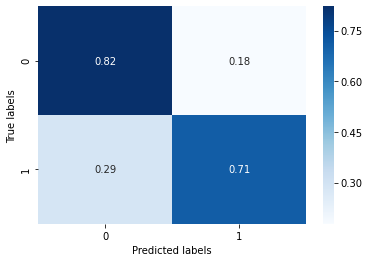

In [27]:
cm = np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [28]:
cv_results['voting'] = pd.DataFrame(cv_scores_vote)['acc']
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost,voting
0,0.739884,0.676301,0.710983,0.693642,0.745665,0.728324,0.705202,0.763006,0.687861,0.791908
1,0.722543,0.682081,0.739884,0.710983,0.739884,0.728324,0.722543,0.682081,0.676301,0.797688
2,0.739884,0.647399,0.682081,0.664740,0.728324,0.722543,0.751445,0.699422,0.722543,0.763006
3,0.726744,0.668605,0.691860,0.656977,0.726744,0.755814,0.726744,0.726744,0.750000,0.755814
4,0.767442,0.668605,0.732558,0.633721,0.796512,0.767442,0.790698,0.784884,0.773256,0.726744


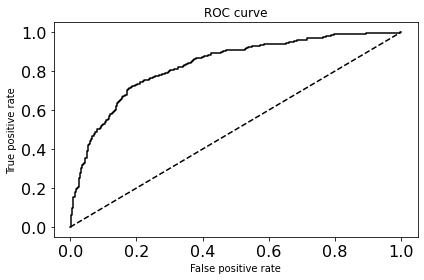

In [29]:
fpr, tpr, _ = roc_curve(cls_data_voting['severity'], cls_data_voting['prob'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Voting', c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend()
plt.tick_params(labelsize=16)
plt.tight_layout()

plt.savefig('fig/filled_{}_binary.png'.format(method), format='png')

In [30]:
thres = 0.50

In [31]:
acc = accuracy_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
recall = recall_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
cm = confusion_matrix(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
roc = roc_auc_score(cls_data_voting['severity'], cls_data_voting['prob'])
sensitivity, specificity = sensitivity_specificity(cm)

print('roc auc score: \t{}'.format(roc))
print('accuarcy: \t{}'.format(acc))
print('recall: \t{}'.format(recall))
print('sensitivity: \t{}'.format(sensitivity))
print('specificity: \t{}'.format(specificity))
print('confusion matrix: \n{}'.format(cm))

roc auc score: 	0.8318345420359924
accuarcy: 	0.7670915411355735
recall: 	0.7105882352941176
sensitivity: 	0.7105882352941176
specificity: 	0.821917808219178
confusion matrix: 
[[360  78]
 [123 302]]


In [32]:
results = pd.DataFrame(index=base_learners.keys(), columns=['roc', 'acc', 'recall', 'cm', 'sensitivity', 'specificity'], dtype='object')
for k in base_learners.keys():
    acc = accuracy_score(cls_data_voting['severity'], prob[k] > thres)
    recall = recall_score(cls_data_voting['severity'], prob[k] > thres)
    cm = confusion_matrix(cls_data_voting['severity'], prob[k] > thres)
    roc = roc_auc_score(cls_data_voting['severity'], prob[k])
    sensitivity, specificity = sensitivity_specificity(cm)
    results.loc[k, :] = [roc, acc, recall, cm, sensitivity, specificity]

C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

In [33]:
results.to_csv('./csv/cross_validation_trainSet/filled_{}_binary.csv'.format(method))

[Text(0.5, 0, 'Classifcation Methods'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, '5-Fold Cross Validation Accuracy')]

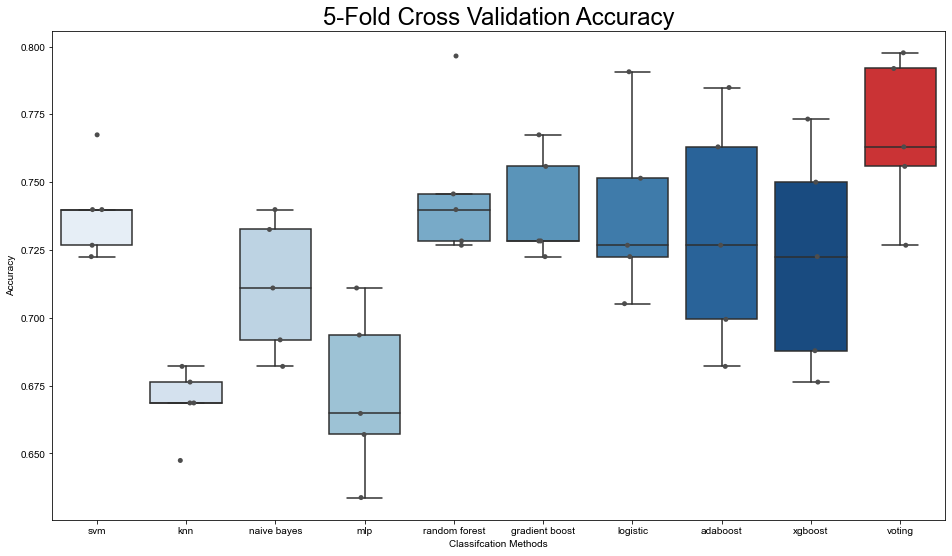

In [34]:
plt.subplots(figsize=(16, 9))
sns.set(style="ticks")
sns.set(font_scale=2.0)
colors = sns.color_palette("Blues", len(base_learners.keys()))
colors.append((0.8901960784313725, 0.10196078431372549, 0.10980392156862745))
dx = sns.boxplot(data=cv_results, palette=colors, boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(data=cv_results,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
dx.set(xlabel='Classifcation Methods',ylabel='Accuracy', title='5-Fold Cross Validation Accuracy')

In [35]:
P_test = predict_base_learners(base_learners, z_score_normalize(np.array(test_dataset[feature])))
test_dataset['prediction_clinical'] = P_test.mean(axis=1)
test_dataset.to_csv('./csv/prediction_testSet/filled_{}_binary.txt'.format(method))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
